# Tesseract - Image Preprocessing

Um die Ergebnisse der Textextraktion mit tesseract zu verbessern wird ein Preprocessing der Bilder vorgenommen.  
Dabei werden verschiedene Möglichkeiten der Bildbearbeitung mit OpenCV genutzt und untersucht, ob diese eine positiven Einfluss auf die Qualität der Textextraktion haben.    
Da vorherige Untersuchungen ergeben haben, dass ein Vergleich des ground truth mit dem OCR-Text auf Zeilenebene eine bessere Einschätzung zur Word Error Rate (WER) ermöglicht, welche für die Arbeit relevanter ist als Character Error Rate (CER), wird die Evaluation auch in diesem Notebook zeilenweise vorgenommen.

### Preprocessing
Um zu Testen, ob und ggf. die Perfomance des Modells mit vorheriger Bildbearbeitung verbessert werden kann, werden in diesem Notebook drei Bilder beispielhaft einem sogenanntes Preprocessing unterzogen. Das bedeutet, dass sie vorher bearbeitet werden, damit tesseract Text auf dem Bild besser erkennen kann.
Dazu wird OpenCV benutzt.

---

#### 1. Preprocessing auf einem einzelnen Bild
Zunächst wird der Prozess auf einem Bild getestet  
Nach jedem Schritt wird, OCR Textextraktion angewendet und auf die Qualität hin untersucht. Es wird dafür CER und WER berechnet.

In [ ]:
#!pip install opencv-python

In [3]:
import cv2
print(cv2.__version__)

4.11.0


In [4]:
# Funktion, um Bilder im notebook anzeigen zu lassen
from matplotlib import pyplot as plt

def show_image(img, title="Bild", cmap="gray"):
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [10]:
# Funktion für tesseract Textextraktion und Berechnung WER und CER
import os
import json
import numpy as np
from PIL import Image
import pytesseract
import re
import Levenshtein
import pandas as pd
import jiwer
from jiwer import wer, cer

             
DIR_PATH = "../../../data/images/insta_images"
JSON = "../../../data/data_annotated.json"
CER_THRESHOLD = 0.4                 # ← Maximaler Fehlerwert für Match (40% Fehler erlaubt)



### Hilfsfunktionen ####

# CER fürs Matching der Zeilen ground truth und OCR
def cer_for_matching(gt, pred):
    gt = re.sub(r"\s+", "", gt) # entfernt ALLE whitespaces, auch tabs und Zeilenumbrüche, macht merh als strip()
    pred = re.sub(r"\s+", "", pred)
    if not gt:
        return 0.0 if not pred else 1.0
    return Levenshtein.distance(gt, pred) / len(gt)

# Textextraktion zeilenweise Ausgabe
def extract_ocr_lines(image_path):
    img = Image.open(image_path)
    data = pytesseract.image_to_data(img, lang="deu", output_type=pytesseract.Output.DATAFRAME)
    lines = data[data['level'] == 5] 
    grouped = lines.groupby(['block_num', 'par_num', 'line_num'])
    # erzeugt Liste mit den einzelen Zeilen in denen der Text bereinigt von NAN Werten als einzelner String zuammengefasst wurde
    line_texts = grouped['text'].apply(lambda x: ' '.join(x.dropna())).tolist() 
    return line_texts

# Zeilen matchen mit minimalen CER
def match_gt_to_ocr(gt_lines, ocr_lines, max_cer_threshold):
    matched = []
    used_ocr_indices = set()

    for gt_idx, gt_line in enumerate(gt_lines):
        best_score = float('inf')
        best_ocr_idx = None
        best_ocr_line = ""

        for ocr_idx, ocr_line in enumerate(ocr_lines):
            if ocr_idx in used_ocr_indices:
                continue
            cer = cer_for_matching(gt_line, ocr_line)
            if cer < best_score:
                best_score = cer
                best_ocr_idx = ocr_idx
                best_ocr_line = ocr_line

        if best_score <= max_cer_threshold:
            matched.append((gt_idx, best_ocr_idx))
            used_ocr_indices.add(best_ocr_idx)
        else:
            matched.append((gt_idx, None))
    return matched


def calculate_wer(gt, pred):
    word_error = wer(gt, pred)
    return word_error
    
def calculate_cer(gt, pred):
    char_error = cer(gt, pred)
    return char_error


### Hauptfunktion ####

def ocr_text_eval(image_path, image_name):

    mean_cer = None
    mean_wer = None
    total_matches = 0
    total_lines = 0
    
    with open(JSON, "r", encoding="utf-8") as f:
        all_data = json.load(f)

    #image = os.path.basename(image_path)
    
    eintrag = next((item for item in all_data if item.get("file_name") == image_name), None)
    if eintrag is None:
        print(f"Kein Groundtruth-Eintrag für {image_name}")
    else:
        gt_lines = eintrag["lines"]
        total_lines = len(gt_lines)
        img_path = image_path
    
        if not os.path.exists(img_path):
            print(f"Bild nicht gefunden: {img_path}")
        else:
            ocr_lines = extract_ocr_lines(img_path)
            matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

            cer_scores = []
            wer_scores = []
            total_matches = 0
    
            for gt_idx, ocr_idx in matches:
                gt_line = gt_lines[gt_idx]
                if ocr_idx is not None:
                    ocr_line = ocr_lines[ocr_idx]
                    cer_score = calculate_cer(gt_line, ocr_line)
                    wer_score = calculate_wer(gt_line, ocr_line)
                    total_matches += 1
                else:
                    ocr_line = "[Nicht erkannt]"
                    cer_score = 1.0
                    wer_score = 1.0
                    
                cer_scores.append(cer_score)
                wer_scores.append(wer_score)
     
            mean_cer = np.mean(cer_scores) # Liste muss in NumPy Array umgewandelt werden, damit mean funktioniert
            mean_wer = np.mean(wer_scores)
    
        return {
            "mean_cer": mean_cer,
            "mean_wer": mean_wer,
            "matched_lines": total_matches,
            "total_lines": total_lines
        }
    
    


---

#### 1.1. Preprocessing - Beispiel - Bild 1

In [7]:
import pytesseract
from PIL import Image

image_file = "../../../data/images/insta_images/0001.jpg"
img1 = cv2.imread(image_file) 

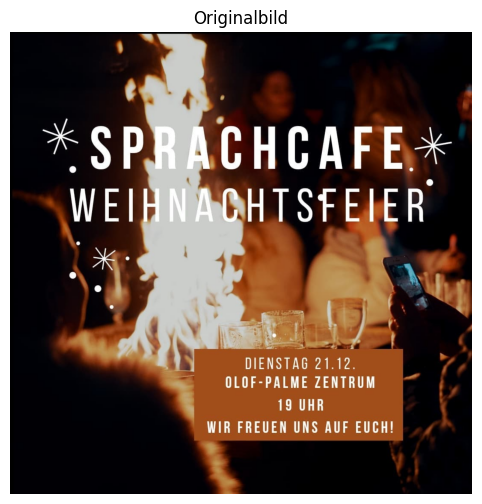

In [8]:
image_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # zuerst img in RGB ändern, sonst Ausgabe als BGR - Rot und Blau "vertauscht"
show_image(image_rgb, "Originalbild", cmap=None)

In [11]:
# OCR Evaluation auf Originalbild ohne Preprocessing
print(ocr_text_eval("../../../data/images/insta_images/0001.jpg", "0001.jpg"))

{'mean_cer': 0.35185185185185186, 'mean_wer': 0.4166666666666667, 'matched_lines': 4, 'total_lines': 6}


##### GRAUSTUFEN

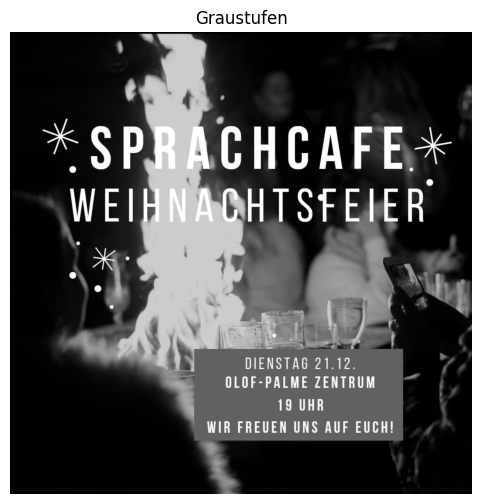

True

In [15]:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
show_image(gray, "Graustufen")
os.makedirs("temp_img_preprocessed", exist_ok=True)
cv2.imwrite("temp_img_preprocessed/gray.jpg", gray)

In [16]:
print(ocr_text_eval("temp_img_preprocessed/gray.jpg", "0001.jpg"))

{'mean_cer': 1.0, 'mean_wer': 1.0, 'matched_lines': 0, 'total_lines': 6}


##### RAUSCHEN ENTFERNEN

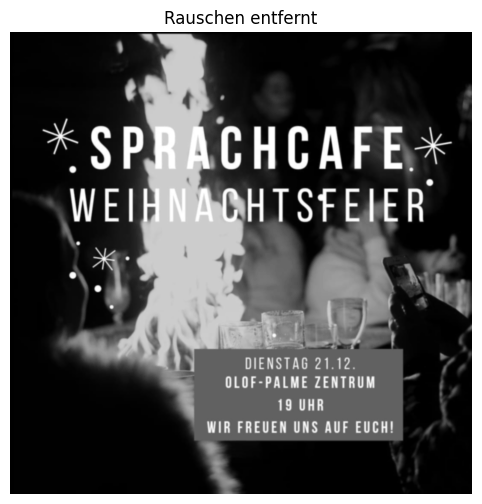

{'mean_cer': 1.0, 'mean_wer': 1.0, 'matched_lines': 0, 'total_lines': 6}


In [17]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
show_image(blur, "Rauschen entfernt")
cv2.imwrite("temp_img_preprocessed/blur.jpg", blur)
print(ocr_text_eval("temp_img_preprocessed/blur.jpg", "0001.jpg"))

##### BINARISIERUNG

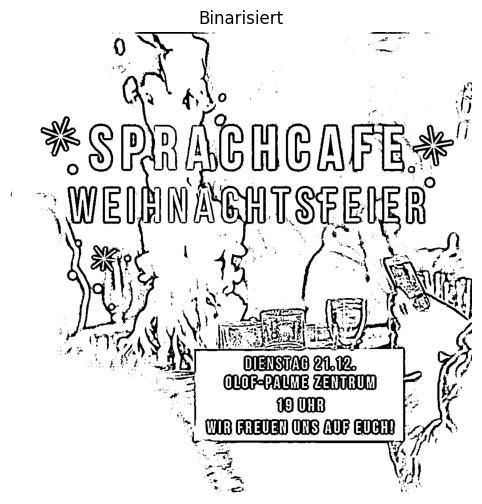

{'mean_cer': 1.0, 'mean_wer': 1.0, 'matched_lines': 0, 'total_lines': 6}


In [18]:
binarise = cv2.adaptiveThreshold(
    blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)
show_image(binarise, "Binarisiert")
cv2.imwrite("temp_img_preprocessed/binarise.jpg", blur)
print(ocr_text_eval("temp_img_preprocessed/binarise.jpg", "0001.jpg"))

##### INVERTIEREN

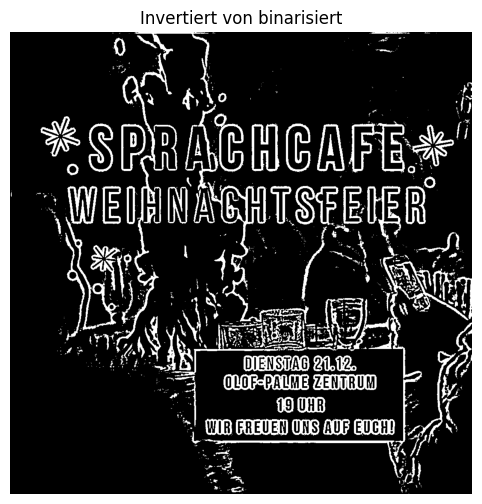

{'mean_cer': 0.8518518518518517, 'mean_wer': 1.0, 'matched_lines': 1, 'total_lines': 6}


In [19]:
inverted_b = cv2.bitwise_not(binarise)
show_image(inverted_b, "Invertiert von binarisiert")
cv2.imwrite("temp_img_preprocessed/inverted_b.jpg", inverted_b)
print(ocr_text_eval("temp_img_preprocessed/inverted_b.jpg", "0001.jpg"))

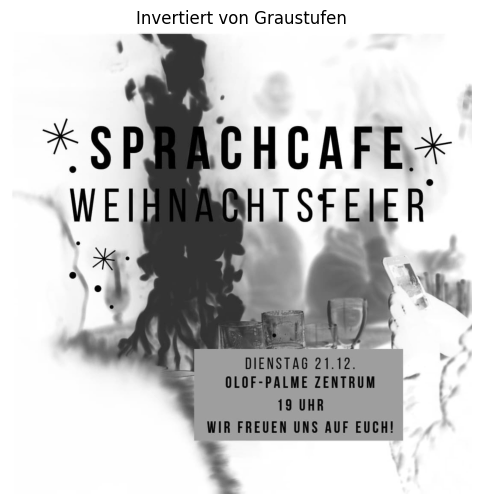

{'mean_cer': 1.0, 'mean_wer': 1.0, 'matched_lines': 0, 'total_lines': 6}


In [20]:
inverted_g = cv2.bitwise_not(gray)
show_image(inverted_g, "Invertiert von Graustufen")
cv2.imwrite("temp_img_preprocessed/inverted_g.jpg", inverted_g)
print(ocr_text_eval("temp_img_preprocessed/inverted_g.jpg", "0001.jpg"))

##### KONTRAST

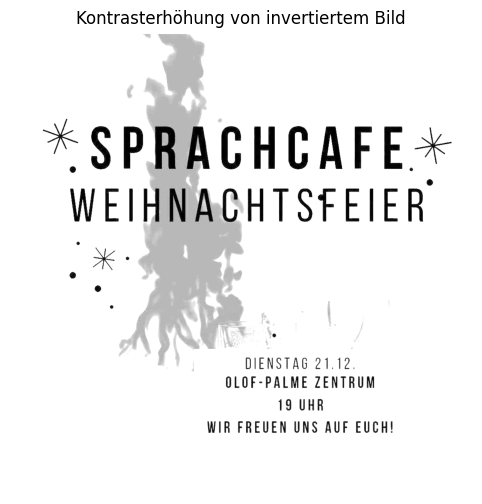

{'mean_cer': 0.049999999999999996, 'mean_wer': 0.16666666666666666, 'matched_lines': 6, 'total_lines': 6}


In [21]:
#define the alpha and beta
# mehrere Werte ausprobiert beste Kombi bei 3.5 und 8
alpha = 3.5 # Contrast control
beta = 8 # Brightness control

# call convertScaleAbs function
contrast = cv2.convertScaleAbs(inverted_g, alpha=alpha, beta=beta)
show_image(contrast, "Kontrasterhöhung von invertiertem Bild")
cv2.imwrite("temp_img_preprocessed/contrast.jpg", contrast)
print(ocr_text_eval("temp_img_preprocessed/contrast.jpg", "0001.jpg"))

#### ---> die Kontrasterhöhung bei invertiertem Bild hat das Ergebnis signifikant verbessert

|                        | Mean CER | Mean WER | Matched Lines | Total Lines |
|------------------------|----------|----------|----------------|--------------|
| **Vor Preprocessing**  | 0.352    | 0.417    | 4              | 6            |
| **Nach Preprocessing** | 0.050    | 0.167    | 6              | 6            |


---


#### 1.2. Preprocessing - Beispiel - Bild 2

In [22]:
image_file = "../../../data/images/insta_images/0002.jpg"
img2 = cv2.imread(image_file) 

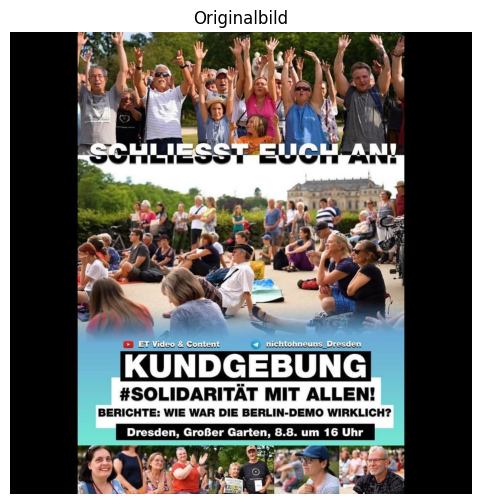

In [23]:
image_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # zuerst img in RGB ändern, sonst Ausgabe als BGR - Rot und Blau "vertauscht"
show_image(image_rgb, "Originalbild", cmap=None)

In [22]:
# OCR Evaluation auf Originalbild ohne Preprocessing
print(ocr_text_eval("../../../data/images/insta_images/0002.jpg", "0002.jpg"))

{'mean_cer': 0.5714285714285714, 'mean_wer': 0.5714285714285714, 'matched_lines': 3, 'total_lines': 7}


##### GRAUSTUFEN

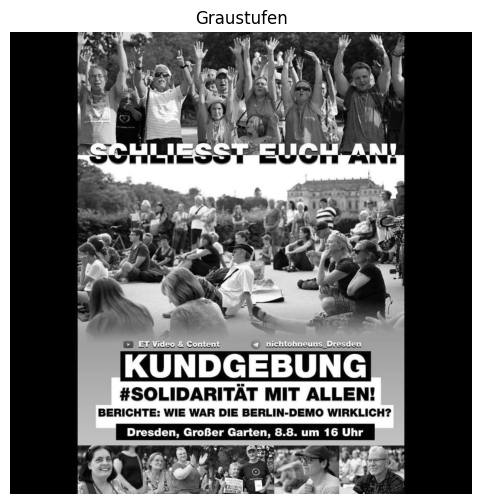

{'mean_cer': 0.7142857142857143, 'mean_wer': 0.7142857142857143, 'matched_lines': 2, 'total_lines': 7}


In [24]:
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
show_image(gray2, "Graustufen")
cv2.imwrite("temp_img_preprocessed/gray2.jpg", gray2)
print(ocr_text_eval("temp_img_preprocessed/gray2.jpg", "0002.jpg"))

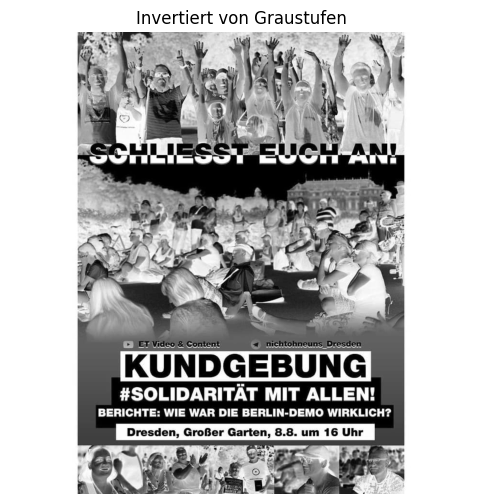

{'mean_cer': 0.5714285714285714, 'mean_wer': 0.5714285714285714, 'matched_lines': 3, 'total_lines': 7}


In [26]:
inverted2= cv2.bitwise_not(gray2)
show_image(inverted2, "Invertiert von Graustufen")
cv2.imwrite("temp_img_preprocessed/inverted2.jpg", inverted2)
print(ocr_text_eval("temp_img_preprocessed/inverted2.jpg", "0002.jpg"))

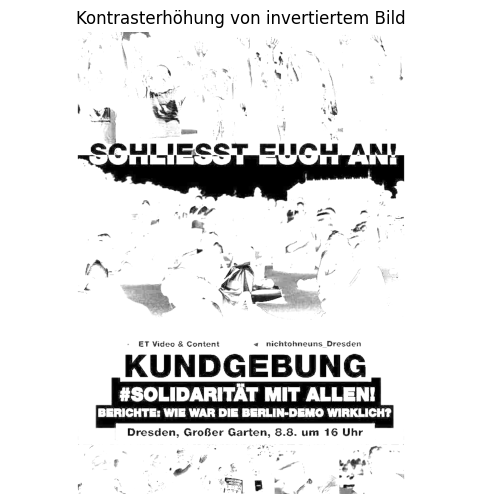

{'mean_cer': 0.42857142857142855, 'mean_wer': 0.42857142857142855, 'matched_lines': 4, 'total_lines': 7}


In [27]:
#define the alpha and beta
alpha = 4.5 # Contrast control  - mehrere Werte ausporbiert bei 4.5 bester Output
beta = 8 # Brightness control  - mehrere Werte ausporbiert bei 8 bester Output

# call convertScaleAbs function
contrast2 = cv2.convertScaleAbs(inverted2, alpha=alpha, beta=beta)
show_image(contrast2, "Kontrasterhöhung von invertiertem Bild")
cv2.imwrite("temp_img_preprocessed/contrast2.jpg", contrast2)
print(ocr_text_eval("temp_img_preprocessed/contrast2.jpg", "0002.jpg"))

#### ---> die Kontrasterhöhung bei invertiertem Bild hat auch hier das Ergebnis verbessert

|                        | Mean CER | Mean WER | Matched Lines | Total Lines |
|------------------------|----------|----------|----------------|--------------|
| **Vor Preprocessing**  | 0.571    | 0.571    | 3              | 7            |
| **Nach Preprocessing** | 0.429    | 0.429    | 4              | 7            |


---

#### 1.3. Preprocessing - Beispiel - Bild 3

In [37]:
image_file = "../../../data/images/insta_images/0227.jpg"
img3 = cv2.imread(image_file) 

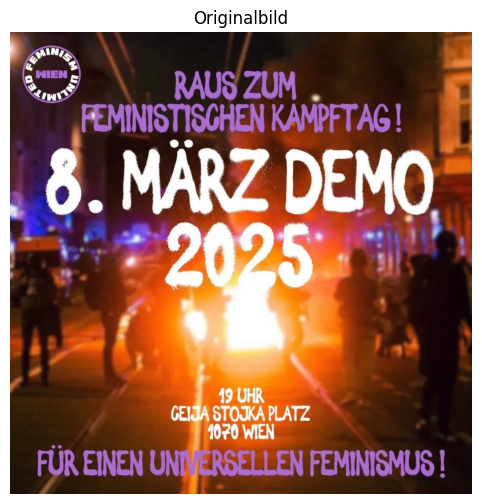

In [38]:
image_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB) # zuerst img in RGB ändern, sonst Ausgabe als BGR - Rot und Blau "vertauscht"
show_image(image_rgb, "Originalbild", cmap=None)

In [39]:
# OCR Evaluation auf Originalbild ohne Preprocessing
print(ocr_text_eval("../../../data/images/insta_images/0227.jpg", "0227.jpg"))

{'mean_cer': 1.0, 'mean_wer': 1.0, 'matched_lines': 0, 'total_lines': 8}


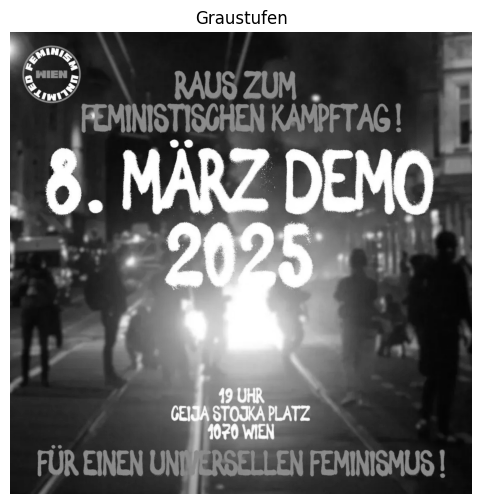

{'mean_cer': 0.8823529411764706, 'mean_wer': 0.96875, 'matched_lines': 1, 'total_lines': 8}


In [40]:
gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
show_image(gray3, "Graustufen")
cv2.imwrite("temp_img_preprocessed/gray3.jpg", gray3)
print(ocr_text_eval("temp_img_preprocessed/gray3.jpg", "0227.jpg"))

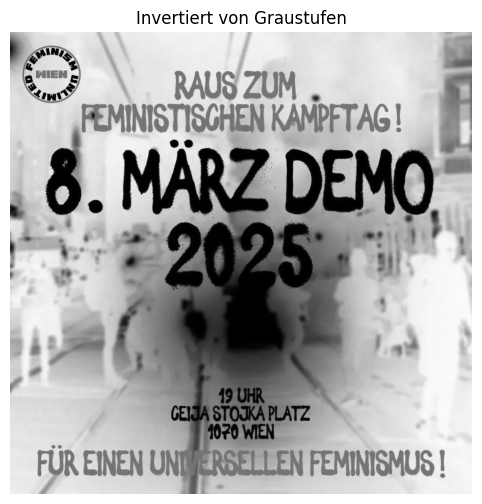

{'mean_cer': 0.8823529411764706, 'mean_wer': 0.96875, 'matched_lines': 1, 'total_lines': 8}


In [41]:
inverted3 = cv2.bitwise_not(gray3)
show_image(inverted3, "Invertiert von Graustufen")
cv2.imwrite("temp_img_preprocessed/inverted3.jpg", inverted3)
print(ocr_text_eval("temp_img_preprocessed/inverted3.jpg", "0227.jpg"))

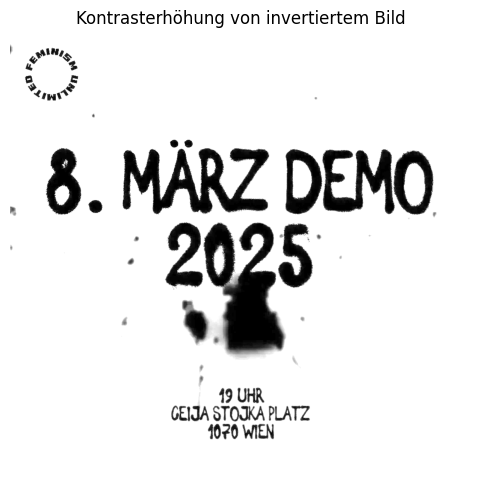

{'mean_cer': 0.4340277777777778, 'mean_wer': 0.5833333333333333, 'matched_lines': 5, 'total_lines': 8}


In [42]:
#define the alpha and beta
#besten werte:
alpha = 5 # Contrast control  
beta = 4 # Brightness control  

# call convertScaleAbs function
contrast3 = cv2.convertScaleAbs(inverted3, alpha=alpha, beta=beta)
show_image(contrast3, "Kontrasterhöhung von invertiertem Bild")
cv2.imwrite("temp_img_preprocessed/contrast3.jpg", contrast3)
print(ocr_text_eval("temp_img_preprocessed/contrast3.jpg", "0227.jpg"))

#### ---> das Preprocessing hat auch hier das Ergebnis verbessert, bzw überhaupt erst Textextraktion für Tesseract möglich gemacht

|                        | Mean CER | Mean WER | Matched Lines | Total Lines |
|------------------------|----------|----------|----------------|--------------|
| **Vor Preprocessing**  | 1.000    | 1.000    | 0              | 8            |
| **Nach Preprocessing** | 0.434    | 0.583    | 5              | 8            |


---

#### **PROBLEM:**

Das Preprocessing hat nur bei individueller Anpassung der Parameter für bessere Ergebnisse gesorgt. Eine automatisches Preprocessing auf einem Datensatz mit sehr unterscheidlichen Bildern würde nicht konsistent zu besseren Ergebnissen führen, wenn man Parameter nicht individuell anpasst.

#### **IDEE:**

Das Preprocessing wird iterativ angewandt. Bei jeder Iteration wird ein andere Kombination an Parametern benutzt, extrahierte Textzeilen werden pro Durchgang gespeichert und mit schon extrahierten Zeilen verglichen. Existiert die Zeile schon, wird sie verworfen. Neue Textzeilen werden gespeichert. Bei ähnlichen Textzeilen wird die Zeilen mit der höheren Zeichenanzahl behalten, in der Annahme, dass durch Preprocessing mehr Zeichen erkannt werden.  
